<a href="https://colab.research.google.com/github/LeoVogiatzis/medical_data_analysis/blob/main/cardio_train_interpretable_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from numpy import loadtxt
from xgboost import XGBClassifier

import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install eli5

import warnings
warnings.simplefilter('ignore')
import os#Walking through directores

import plotly.graph_objects as go # Generate Graphs
from plotly.subplots import make_subplots #To Create Subplots
pd.set_option('display.max_columns', None)#Setting Max Columns Display to Max inorder to get glance of all features in dataframe

     |████████████████████████████████| 112kB 31.6MB/s 


In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving cleaned_cardio_train.csv to cleaned_cardio_train.csv


In [ ]:
import pandas as pd
%matplotlib inline
import io
data = pd.read_csv('/content/cleaned_cardio_train.csv')
#data = pd.read_csv(io.BytesIO(uploaded['cleaned_data_cardio.csv']),sep=';')  

In [ ]:
data.describe()
data.head()

,Unnamed: 0,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse
0,0,50,2,5.123964,4.127134,110,80,1,1,0,0,1,0,21.967120,30.0
1,1,55,1,5.049856,4.442651,140,90,3,1,0,0,1,1,34.927679,50.0
2,2,51,1,5.105945,4.158883,130,70,3,1,0,0,0,1,23.507805,60.0
3,3,48,2,5.129899,4.406719,150,100,1,1,0,0,1,1,28.710479,50.0
4,4,47,1,5.049856,4.025352,100,60,1,1,0,0,0,0,23.011177,40.0


In [ ]:
print(data.head())
# Checking for nan's
data.isnull().any()
data.drop('Unnamed: 0', axis=1, inplace=True)

   Unnamed: 0  age  gender    height    weight  ap_hi  ap_lo  cholesterol  \
0           0   50       2  5.123964  4.127134    110     80            1   
1           1   55       1  5.049856  4.442651    140     90            3   
2           2   51       1  5.105945  4.158883    130     70            3   
3           3   48       2  5.129899  4.406719    150    100            1   
4           4   47       1  5.049856  4.025352    100     60            1   

   gluc  smoke  alco  active  cardio        bmi  pulse  
0     1      0     0       1       0  21.967120   30.0  
1     1      0     0       1       1  34.927679   50.0  
2     1      0     0       0       1  23.507805   60.0  
3     1      0     0       1       1  28.710479   50.0  
4     1      0     0       0       0  23.011177   40.0  


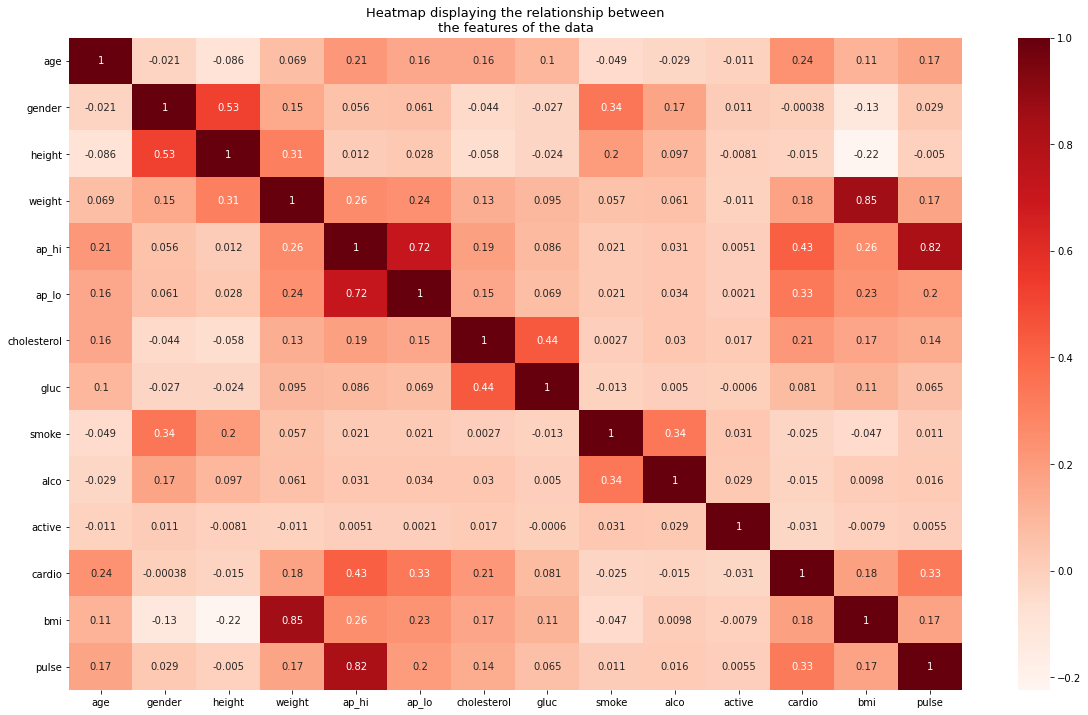

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse
0,50,2,5.123964,4.127134,110,80,1,1,0,0,1,0,21.967120,30.0
1,55,1,5.049856,4.442651,140,90,3,1,0,0,1,1,34.927679,50.0
2,51,1,5.105945,4.158883,130,70,3,1,0,0,0,1,23.507805,60.0
3,48,2,5.129899,4.406719,150,100,1,1,0,0,1,1,28.710479,50.0
4,47,1,5.049856,4.025352,100,60,1,1,0,0,0,0,23.011177,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63933,53,1,5.147494,4.248495,130,90,1,1,0,0,1,1,23.661439,40.0
63934,57,1,5.105945,4.382027,150,80,1,1,0,0,1,1,29.384757,70.0
63935,52,2,5.209486,4.653960,180,90,3,1,0,1,0,1,31.353579,90.0
63936,61,1,5.093750,4.276666,135,80,1,2,0,0,0,1,27.099251,55.0


In [ ]:
corr_df = data.copy()
plt.figure(figsize=(20,12))
sns.heatmap(corr_df.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the relationship between\nthe features of the data',
         fontsize=13)
plt.show()
data


In [ ]:
#X,y = data.drop('cardio', axis=1), data.cardio
# split data into X and y
x_train, x_test, y_train, y_test = train_test_split(data.drop('cardio', axis=1),
                                                        data['cardio'], test_size=0.2)

In [ ]:
print(f'the shape of x_train is {x_train.shape}')
print(f'the shape of y_train is {y_train.shape}')
print(f'the shape of x_test is {x_test.shape}')
print(f'the shape of y_train is {y_test.shape}')

the shape of x_train is (51150, 13)
the shape of y_train is (51150,)
the shape of x_test is (12788, 13)
the shape of y_train is (12788,)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
metrics = {'Accuracy': make_scorer(accuracy_score),
           'Precision': make_scorer(precision_score),
           'Recall': make_scorer(recall_score),
           'F1': make_scorer(f1_score),
}

parameters = {'max_depth': np.arange(2,8), 'criterion':['gini', 'entropy']}
clfr = DecisionTreeClassifier()
grid = GridSearchCV(clfr, param_grid=parameters, cv=8, scoring=metrics, refit='Accuracy',return_train_score=True, verbose=1, n_jobs=-1)
grid.fit(x_train,y_train)
print('The parameters combination that would give best accuracy is : ')
print(grid.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', grid.best_score_)
# model = XGBClassifier()
# model.fit(x_train, y_train)

Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   13.9s finished


The parameters combination that would give best accuracy is : 
{'criterion': 'gini', 'max_depth': 7}
The best accuracy achieved after parameter tuning via grid search is :  0.7260019468969741


In [ ]:
from pprint import pprint
pprint(grid.cv_results_)

{'mean_fit_time': array([0.05817559, 0.07949764, 0.10114172, 0.12271577, 0.14420506,
       0.15819117, 0.06015411, 0.07992768, 0.10678795, 0.12715206,
       0.14803436, 0.17124876]),
 'mean_score_time': array([0.01868808, 0.01920822, 0.0187754 , 0.01906785, 0.01881182,
       0.01975396, 0.01885235, 0.01873896, 0.01917225, 0.0184443 ,
       0.01857957, 0.01882657]),
 'mean_test_Accuracy': array([0.70938414, 0.72140744, 0.72598235, 0.72555229, 0.72582597,
       0.72600195, 0.70938414, 0.72140744, 0.72592369, 0.72557183,
       0.72565001, 0.72578687]),
 'mean_test_F1': array([0.6856729 , 0.71140956, 0.72870923, 0.71504712, 0.72333902,
       0.72524373, 0.6856729 , 0.71140956, 0.72879199, 0.71523936,
       0.72417708, 0.72462395]),
 'mean_test_Precision': array([0.75912633, 0.74916269, 0.73158661, 0.75514372, 0.74067828,
       0.73762668, 0.75912633, 0.74916269, 0.73128997, 0.75483181,
       0.73879265, 0.73814363]),
 'mean_test_Recall': array([0.62521154, 0.67730915, 0.72589809,

Text(0.5, 1.0, 'Accuracy')

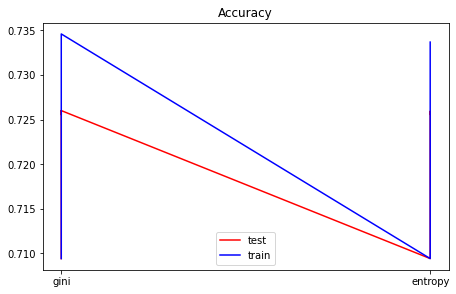

In [ ]:
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(16, 10))
plt.subplot(221)

plt.plot(results['param_criterion'], results['mean_test_Accuracy'], color='red', label='test')
plt.plot(results['param_criterion'], results['mean_train_Accuracy'], color='blue', label='train')
plt.legend()
plt.title('Accuracy')

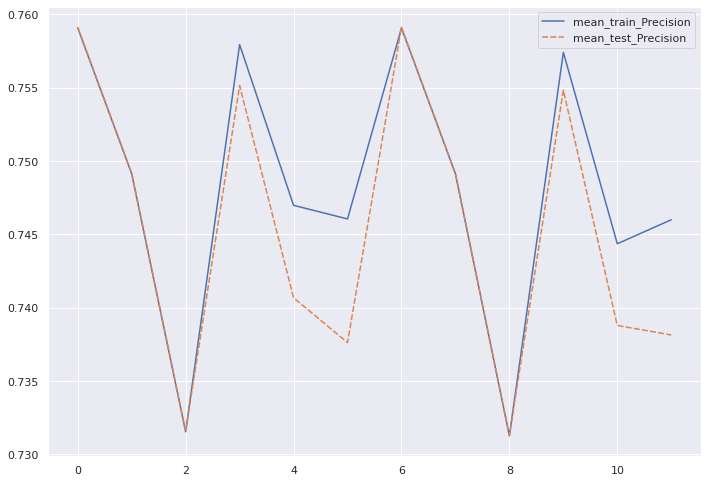

In [ ]:
results = pd.DataFrame(grid.cv_results_)
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=[results['mean_train_Precision'], results['mean_test_Precision']])


In [ ]:
from sklearn.neural_network import MLPClassifier

params = {
        'test1' : [(10,), 'relu', 'sgd', 0.0001],
        'test2' : [(20,), 'tanh', 'sgd', 0.0001],
        'test3': [(50, 50, 50), 'tanh', 'adam', 0.00001],
        'test4': [(50, ), 'relu', 'adam', 0.00001],
        'test5': [(50, 50, 50), 'tanh', 'lbfgs', 0.00001],
        'test6': [(100, 100, 100), 'relu', 'lbfgs', 0.00001]
    }

for k, v in params.items():
  mlp = MLPClassifier(hidden_layer_sizes=params[k][0], activation=params[k][1],
                            solver=params[k][2], tol=params[k][3], max_iter=100)
  mlp.fit(x_train, y_train)
  print('Parameters')
  print([(i) for i in v])
  y_pred = mlp.predict(x_test)
  target_names = ['Class1', 'Class2']
  print(f'Classification report for {str(k)}\n', classification_report(y_test, y_pred, target_names=target_names))
  print(str(accuracy_score))

Parameters
[(10,), 'relu', 'sgd', 0.0001]
Classification report for test1
               precision    recall  f1-score   support

      Class1       0.75      0.60      0.67      6316
      Class2       0.67      0.81      0.73      6472

    accuracy                           0.70     12788
   macro avg       0.71      0.70      0.70     12788
weighted avg       0.71      0.70      0.70     12788

<function accuracy_score at 0x7f4d75e61b90>
Parameters
[(20,), 'tanh', 'sgd', 0.0001]
Classification report for test2
               precision    recall  f1-score   support

      Class1       0.53      0.80      0.64      6316
      Class2       0.61      0.30      0.41      6472

    accuracy                           0.55     12788
   macro avg       0.57      0.55      0.52     12788
weighted avg       0.57      0.55      0.52     12788

<function accuracy_score at 0x7f4d75e61b90>
Parameters
[(50, 50, 50), 'tanh', 'adam', 1e-05]
Classification report for test3
               precision   

In [ ]:
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#ensembling
from mlxtend.classifier import StackingCVClassifier
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(x_train, y_train)
svc_predicted = svc.predict(x_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[4991 1325]
 [2255 4217]]


Accuracy of Support Vector Classifier: 72.00500469189865 

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      6316
           1       0.76      0.65      0.70      6472

    accuracy                           0.72     12788
   macro avg       0.72      0.72      0.72     12788
weighted avg       0.73      0.72      0.72     12788



In [ ]:
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(x_train, y_train)
dt_predicted = dt.predict(x_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[4584 1732]
 [1830 4642]]


Accuracy of DecisionTreeClassifier: 72.14576165154833 

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6316
           1       0.73      0.72      0.72      6472

    accuracy                           0.72     12788
   macro avg       0.72      0.72      0.72     12788
weighted avg       0.72      0.72      0.72     12788



In [ ]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart',)
xgb.fit(x_train, y_train)
xgb_predicted = xgb.predict(x_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))



confussion matrix
[[4721 1595]
 [1991 4481]]


Accuracy of Extreme Gradient Boost: 71.95808570534876 

              precision    recall  f1-score   support

           0       0.70      0.75      0.72      6316
           1       0.74      0.69      0.71      6472

    accuracy                           0.72     12788
   macro avg       0.72      0.72      0.72     12788
weighted avg       0.72      0.72      0.72     12788



In [ ]:

parameters = params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5]
        }
clfr_xb = XGBClassifier()
grid = GridSearchCV(clfr_xb, param_grid=parameters, cv=5, scoring=metrics, refit='Accuracy',return_train_score=True, verbose=1, n_jobs=-1)
grid.fit(x_train,y_train)
print('The parameters combination that would give best accuracy is : ')
print(grid.best_params_)
print('The best accuracy achieved after parameter tuning via grid search is : ', grid.best_score_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  8.6min finished


The parameters combination that would give best accuracy is : 
{'gamma': 5, 'max_depth': 5, 'min_child_weight': 5}
The best accuracy achieved after parameter tuning via grid search is :  0.7324926686217009


In [ ]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=2,max_depth=5)
rf.fit(x_train,y_train)
rf_predicted = rf.predict(x_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[4857 1459]
 [2118 4354]]


Accuracy of Random Forest: 72.0284641851736 

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      6316
           1       0.75      0.67      0.71      6472

    accuracy                           0.72     12788
   macro avg       0.72      0.72      0.72     12788
weighted avg       0.72      0.72      0.72     12788



In [ ]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(x_train,y_train)
nbpred = nb.predict(x_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[5052 1264]
 [2388 4084]]


Accuracy of Naive Bayes model: 71.44197685329998 

              precision    recall  f1-score   support

           0       0.68      0.80      0.73      6316
           1       0.76      0.63      0.69      6472

    accuracy                           0.71     12788
   macro avg       0.72      0.72      0.71     12788
weighted avg       0.72      0.71      0.71     12788



In [ ]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(x_train, y_train)
lr_predict = lr.predict(x_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[4790 1526]
 [1975 4497]]


Accuracy of Logistic Regression: 72.62277134813888 

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      6316
           1       0.75      0.69      0.72      6472

    accuracy                           0.73     12788
   macro avg       0.73      0.73      0.73     12788
weighted avg       0.73      0.73      0.73     12788



In [ ]:
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)
knn_predicted = knn.predict(x_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[4857 1459]
 [2286 4186]]


Accuracy of K-NeighborsClassifier: 70.71473256177666 

              precision    recall  f1-score   support

           0       0.68      0.77      0.72      6316
           1       0.74      0.65      0.69      6472

    accuracy                           0.71     12788
   macro avg       0.71      0.71      0.71     12788
weighted avg       0.71      0.71      0.71     12788



In [ ]:
X,y = data.drop('cardio', axis=1), data.cardio

In [ ]:

model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# evaluate predictions
y_pred = model.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.81%


Feature *Selection

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


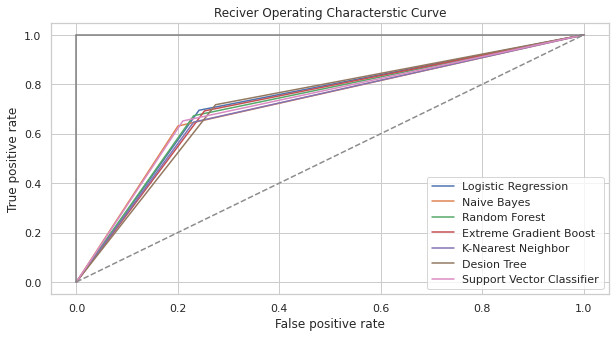

In [ ]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [ ]:
data.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'pulse'],
      dtype='object')

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 26.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491615 sha256=105295d08b3f4236cd0d5579a16bd99ae7a143a9b45b16897ebc7687cc8c3309
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
!pip install eli5

In [ ]:
feature_names = list(x_train.columns)

In [ ]:
from sklearn.svm import SVC
import xgboost
from sklearn.metrics import classification_report
target_names= list(data['cardio'].unique())
#feature_names = list(X.columns)
import eli5
from eli5.sklearn import PermutationImportance
print(target_names)
# feature_names.append('cardio')
print("XGBoost Performance Cardio_dataset:")
model = xgboost.XGBClassifier().fit(x_train,y_train)
y_preds = model.predict(x_test)
print(classification_report(y_test,y_preds,data['cardio']))
perm = PermutationImportance(model).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = feature_names)

[0, 1]
XGBoost Performance Cardio_dataset:


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Weight,Feature
0.1482 ± 0.0050,ap_hi
0.0273 ± 0.0043,cholesterol
0.0205 ± 0.0021,age
0.0013 ± 0.0011,active
0.0006 ± 0.0018,smoke
0.0004 ± 0.0006,alco
0.0002 ± 0.0013,ap_lo
0.0000 ± 0.0009,gluc
-0.0003 ± 0.0009,height
-0.0005 ± 0.0002,pulse


In [ ]:
data2 = data.copy(deep=True)

In [ ]:
data2.drop('Unnamed: 0', axis=True, inplace=True)

KeyError: ignored

In [ ]:
data2.drop(columns=['height', 'weight', 'gender', 'bmi'], axis=1, inplace=True)

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(data2.drop('cardio', axis=1),
                                                        data2['cardio'], test_size=0.2)

In [ ]:
# LIME has one explainer for all models
# !pip install lime
import lime #LIME package
import lime.lime_tabular
explainer.explain_instance(X.iloc[:], xgb_predicted)
# from lime.lime_tabular import LIME_explainerexplainer = LIME_explainer(x_train, feature_names=X.columns, class_names=['cardio'], verbose=True, mode='classification')
#feature_names=x_train.columns.values.tolist(),
# class_names=['cardio'],
# verbose=True, mode='classification')
# for i in data.columns:
#   expXGB = explainer.explain_instance(x_test.values[i], xgb.predict, num_features=5)
#   expXGB.show_in_notebook(show_table=True) 


In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

print('Computing partial dependence plots...')
#tic = time()
features = ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol','smoke', 'bmi', 'pulse']
display = plot_partial_dependence(mlp, x_train, features, 
       n_jobs=3, grid_resolution=20
)
#print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence of house value on non-location features\n'
    'for the California housing dataset, with MLPRegressor'
)
display.figure_.subplots_adjust(hspace=0.3)

In [ ]:
features = ['ap_hi', 'ap_lo', ('ap_hi', 'ap_lo')]
print('Computing partial dependence plots...')
#tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(
    mlp, x_train, features, n_jobs=3, grid_resolution=20,
    ax=ax,
)
#print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence plots for\n'
    'cardio dataset, with Mlp'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

In [ ]:
features = ['ap_hi', 'ap_lo', ('ap_hi', 'ap_lo')]
print('Computing partial dependence plots...')
#tic = time()
_, ax = plt.subplots(ncols=3, figsize=(9, 4))
display = plot_partial_dependence(
    mlp, x_train, features, n_jobs=3, grid_resolution=20,
    ax=ax,
)
#print(f"done in {time() - tic:.3f}s")
display.figure_.suptitle(
    'Partial dependence plots for\n'
    'cardio dataset, with Mlp'
)
display.figure_.subplots_adjust(wspace=0.4, hspace=0.3)

In [ ]:
# Build Random Forest model
#!pip install pdpbox
from pdpbox import pdp, info_plots
# X = data.drop('cardio', axis=1)
# y = data['cardio']
feature_to_plot = 'smoke'
feature_names = [i for i in data.columns]
dataset = data[feature_names]
X = dataset.drop('cardio', axis=1)
y = data['cardio']
x_train2, x_test2, y_train2, y_test2 = train_test_split(data[feature_names],data[feature_names], test_size=18)
rf_model = RandomForestClassifier(random_state=0).fit(x_train, y_train)

pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

In [ ]:
data.columns

In [ ]:
# Visualizing Correlations
plt.figure(figsize=(15, 8))
sns.heatmap(data.corr(method="spearman"), annot=True, vmax=1, vmin=-1)
plt.title("Inter-Correlations between features and labels", fontsize = 15)
plt.show()

In [ ]:
# Visualizing the relations between features and label
plt.figure(figsize=(8, 6))
plt.scatter(data['bmi'], data['cardio'], c="r", alpha=0.4, label="bmi")
plt.scatter(data['height'], y, data['cardio'], alpha=0.4, label="height")
plt.scatter(data['weight'], y, data['cardio'], alpha=0.4, label="weight")
plt.legend()
plt.title("Scatter Plot of Relations between Features and Label", fontsize = 15)
plt.xlabel("Features")
plt.ylabel("Outcome")
plt.show()

In [ ]:
def get_distribution(col_name, data, model):
    x = data.copy()
    sequence = np.linspace(np.min(data[col_name]), np.max(data[col_name]), len(data[col_name]))
    y_dist = []
    ice_avgs = []
    for elem in sequence:
        x[col_name] = elem
        y_temp = model.predict(x)
        y_dist.append(np.mean(y_temp))
        
        ice_avgs.append(y_temp)
        
    return sequence, y_dist, ice_avgs

In [ ]:
def plot_PDP(col_name, data, model, xlabel, ylabel):
    plt.figure(figsize = (10, 8))
    plt.grid()
    res = get_distribution(col_name, data, model)
    plt.plot(res[0], res[1], lw = 2, label = 'Trend')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(fontsize = 'large')
    plt.tight_layout()

In [ ]:

def plot_ICE(col_name, data, model, xlabel, ylabel):
    res = get_distribution(col_name, data, model)
    x = res[0]
    ice_avgs = res[2]
    plt.figure(figsize = (12, 8))
    plt.grid()
    for row in range(len(ice_avgs[0])):
        ys = []
        for item in range(len(ice_avgs)):
            ys.append(ice_avgs[item][row])
        plt.plot(x, ys, c = 'black', alpha = 0.1)
        
    plt.plot(res[0], res[1], lw = 5, c = 'r', label = 'Avg. Trend (PDP)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize = 'large')
    plt.tight_layout()

In [ ]:
plot_PDP('ap_hi', x_train, mlp, "ap_hi", "Median Housing Prices in $1000's")

In [ ]:
plot_ICE('ap_hi', x_train, mlp, "ap_hi", "X_train")
plt.scatter(X_train_reduced['DIS'], y_train, label = 'Individual Instances', edgecolors = 'b', color = 'orange')
plt.legend()

In [ ]:

def supervised_comparison(df: pd.DataFrame) ->pd.DataFrame:

    X, y = df.drop(columns='cardio'), df['cardio']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=119, stratify=y)

    # define the models along with the respective grid search parameters
    # logistic regression
    log_reg_clf = LogisticRegression()
    log_reg_params = {}
    # random forest
    rf_clf = RandomForestClassifier()
    rf_params = {'n_estimators': range(20, 36)}
    # naive bayes
    nb_clf = BernoulliNB()
    nb_params = {'alpha': [x * 0.005 for x in range(1, 10)]}


    # calculate metrics for various combinations 
    metrics_df = pd.DataFrame()
    for model_name, model, model_params in zip(['Logistic Regression', 'Random Forest', 'Naive Bayes'],
                                            [log_reg_clf, rf_clf, nb_clf],
                                            [log_reg_params, rf_params, nb_params]):
        print(f'Calculating results of {model_name} classifier')
        scaler = MinMaxScaler()
        pipe = Pipeline([('scaling', scaler),
                            ('classifier', model)])
        # grid search 
        grid = GridSearchCV(model,
                        param_grid=model_params,
                        cv=5,
                        n_jobs=-1)
        grid.fit(X_train, y_train)
        # change the classifier in the pipe to the best classifier after frid search 
        pipe = Pipeline([('scaling', scaler),
                            ('classifier',  grid.best_estimator_)])

        pipe.fit(X_train, y_train)

        # results
        y_pred = pipe.predict(X_test)
        results_df = model_evaluation(y_test, y_pred, labels_dict={0: 'Not_Cardio', 1: 'Cardio'}, model_name=model_name)
        metrics_df = metrics_df.append(results_df)

    return metrics_df

In [ ]:
def model_evaluation(y_test, prediction, labels_dict, model_name) ->pd.DataFrame:
   """
   
   """ # metrics
    accuracy = accuracy_score(y_test, prediction)
    recall = recall_score(y_test, prediction, average='macro')
    precision = precision_score(y_test, prediction, average='macro')
    f1 = f1_score(y_test, prediction, average='macro')

    print('Accuracy score: {:.3f}'.format(accuracy))
    print('Recall score: {:.3f}'.format(recall))
    print('Precision score: {:.3f}'.format(precision))
    print('F1 score: {:.3f}'.format(f1))

    print('Classification report:\n{}'.format(classification_report(y_test, prediction, target_names=list(labels_dict.values()))))

    # confusion matrix
    cm = confusion_matrix(y_test, prediction)

    df_cm = pd.DataFrame(cm, index=list(labels_dict.values()), columns=list(labels_dict.values()))
    plt.figure(figsize=(10,6))
    plt.title(f'Confusion matrix of {model_name} results')
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f')

    #plt.savefig('_matrix.png'.format(title))
    plt.show()

    df = pd.DataFrame(data={'metric': ['accuracy', 'recall', 'precision', 'f1'],
                            'score': [accuracy*100, recall*100, precision*100, f1*100],
                            'model': model_name}) 
    return df 

In [ ]:
metrics_df = supervised_comparison(data)